In [1]:
import os
import cv2

# Root folder where images are stored
root_folder = "images"  # Change this to your dataset root folder

# Subfolders to process
subfolders = ["train", "test", "val"]

for subfolder in subfolders:
    folder_path = os.path.join(root_folder, subfolder)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        
        # Read image in color
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Skipping: {img_path} (Invalid image)")
            continue
        
        # Convert to grayscale (black & white)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Overwrite the original image
        cv2.imwrite(img_path, gray_img)

print("All images successfully converted to grayscale!")


Skipping: images\train\Thumbs.db (Invalid image)
Skipping: images\test\Thumbs.db (Invalid image)
Skipping: images\val\Thumbs.db (Invalid image)
All images successfully converted to grayscale!


In [ ]:
import os
import cv2
import numpy as np

# Root folder where images are stored
root_folder = "images"
subfolders = ["train", "test", "val"]
target_size = (256, 256)  # Change this based on your dataset

x_data, y_data = {}, {}



def apply_gaussian_white_blur(img):
    """Applies a Gaussian white blur that stays strong longer and then decreases rapidly."""
    img = cv2.resize(img, target_size)
    h, w = img.shape
    blur_region = int(0.3 * h)  # Bottom 30% gets blurred

    # Create coordinate grids for a 2D mask
    y_coords = np.linspace(0, 1, blur_region, dtype=np.float32).reshape(-1, 1)
    x_coords = np.linspace(0, 1, w, dtype=np.float32).reshape(1, -1)
    
    # Modify the Gaussian function to maintain strength and drop sharply
    mask = np.exp(-1 * (0.5*(x_coords - 0.5) ** 2 + 0.8*(y_coords - 1) ** 2))  # Adjusted decay
    mask = (mask - mask.min()) / (mask.max() - mask.min())  # Normalize 0-1

    # Convert image to float for smooth blending
    img_blurred = img.astype(np.float32)

    # Apply blur effect on bottom region
    img_blurred[-blur_region:, :] = img_blurred[-blur_region:, :] * (1 - mask) + 255 * mask

    return img_blurred.astype(np.uint8)


for subfolder in subfolders:
    folder_path = os.path.join(root_folder, subfolder)
    
    x_list, y_list = [], []

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        # Ignore non-image files
        if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
            print(f"Skipping: {img_path} (Not an image)")
            continue
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping: {img_path} (Invalid image)")
            continue
        
        # Resize images to fixed size
        img_resized = cv2.resize(img, target_size)

        x_blurred = apply_gaussian_white_blur(img_resized)
        y_original = img_resized  # Ground truth

        x_list.append(x_blurred)
        y_list.append(y_original)

    x_data[subfolder] = np.array(x_list, dtype=np.uint8)
    y_data[subfolder] = np.array(y_list, dtype=np.uint8)

# Save as NumPy arrays
np.save("x_train.npy", x_data["train"])
np.save("y_train.npy", y_data["train"])
np.save("x_test.npy", x_data["test"])
np.save("y_test.npy", y_data["test"])
np.save("x_val.npy", x_data["val"])
np.save("y_val.npy", y_data["val"])

print("Dataset prepared! NumPy arrays saved.")


Skipping: images\train\Thumbs.db (Not an image)
Skipping: images\test\Thumbs.db (Not an image)
Skipping: images\val\Thumbs.db (Not an image)
Dataset prepared! NumPy arrays saved.


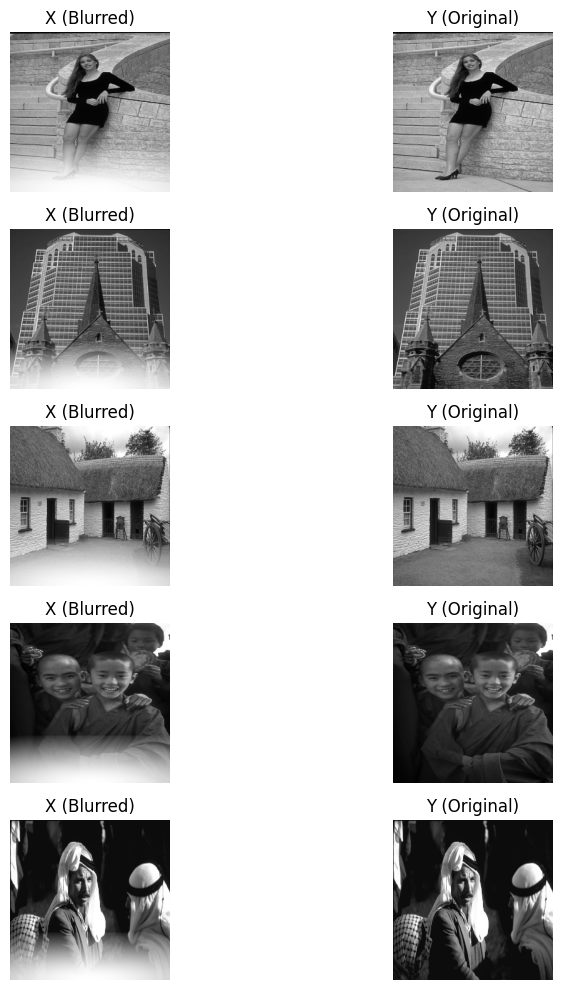

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

# Select 5 random indices
num_samples = 5
random_indices = np.random.choice(len(x_train), num_samples, replace=False)

# Plot images side by side
plt.figure(figsize=(10, num_samples * 2))

for i, idx in enumerate(random_indices):
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(x_train[idx], cmap="gray")
    plt.title("X (Blurred)")
    plt.axis("off")

    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(y_train[idx], cmap="gray")
    plt.title("Y (Original)")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
from tqdm import tqdm


In [5]:
class ImageDataset(Dataset):
    def __init__(self, x_paths, y_paths, transform=None):
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.transform = transform

    def __len__(self):
        return len(self.x_paths)

    def __getitem__(self, idx):
        x = cv2.imread(self.x_paths[idx], cv2.IMREAD_GRAYSCALE)
        y = cv2.imread(self.y_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Normalize images to [0,1]
        x = x.astype(np.float32) / 255.0
        y = y.astype(np.float32) / 255.0

        x = torch.tensor(x).unsqueeze(0)  # Add channel dimension
        y = torch.tensor(y).unsqueeze(0)

        return x, y


In [6]:


# Load saved numpy arrays
x_train = np.load("x_train.npy")  # Blurred training images
y_train = np.load("y_train.npy")  # Original training images

x_val = np.load("x_val.npy")  # Blurred validation images
y_val = np.load("y_val.npy")  # Original validation images

x_test = np.load("x_test.npy")  # Blurred test images
y_test = np.load("y_test.npy")  # Original test images

# Ensure images are in [0,1] range
x_train, y_train = x_train.astype(np.float32) / 255.0, y_train.astype(np.float32) / 255.0
x_val, y_val = x_val.astype(np.float32) / 255.0, y_val.astype(np.float32) / 255.0
x_test, y_test = x_test.astype(np.float32) / 255.0, y_test.astype(np.float32) / 255.0


In [7]:
class NPImageDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data).unsqueeze(1)  # Add channel dim
        self.y_data = torch.tensor(y_data).unsqueeze(1)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]


In [8]:
# Create datasets
train_dataset = NPImageDataset(x_train, y_train)
val_dataset = NPImageDataset(x_val, y_val)
test_dataset = NPImageDataset(x_test, y_test)

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder (Downsampling)
        self.conv1 = self.double_conv(1, 64)  # Grayscale input (1 channel)
        self.conv2 = self.double_conv(64, 128)
        self.conv3 = self.double_conv(128, 256)
        self.conv4 = self.double_conv(256, 512)
        
        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        
        # Decoder (Upsampling)
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.double_conv(1024, 512)

        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.double_conv(512, 256)

        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.double_conv(256, 128)

        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.double_conv(128, 64)

        # Output layer (1-channel for grayscale reconstruction)
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)
    
    def double_conv(self, in_channels, out_channels):
        """Convolutional block: Conv -> ReLU -> Conv -> ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        """Upsampling block: Transposed Convolution"""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    
    def forward(self, x):
        """Forward pass for U-Net"""
        # Encoder
        x1 = self.conv1(x)
        x2 = self.conv2(F.max_pool2d(x1, 2))
        x3 = self.conv3(F.max_pool2d(x2, 2))
        x4 = self.conv4(F.max_pool2d(x3, 2))
        
        # Bottleneck
        x_bottleneck = self.bottleneck(F.max_pool2d(x4, 2))
        
        # Decoder
        x_up4 = self.upconv4(x_bottleneck)
        x_up4 = torch.cat([x_up4, x4], dim=1)  # Skip connection
        x_up4 = self.dec4(x_up4)

        x_up3 = self.upconv3(x_up4)
        x_up3 = torch.cat([x_up3, x3], dim=1)
        x_up3 = self.dec3(x_up3)

        x_up2 = self.upconv2(x_up3)
        x_up2 = torch.cat([x_up2, x2], dim=1)
        x_up2 = self.dec2(x_up2)

        x_up1 = self.upconv1(x_up2)
        x_up1 = torch.cat([x_up1, x1], dim=1)
        x_up1 = self.dec1(x_up1)

        # Output layer (single grayscale channel)
        output = self.out_conv(x_up1)
        return output


In [10]:
import torch.optim as optim

# Load model and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

# Loss function (Mean Squared Error for image reconstruction)
criterion = nn.MSELoss()

# Optimizer (Adam is usually a good choice)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")


KeyboardInterrupt: 